### Categorizing NIPS papers using LDA topic modeling

The LDA code is adapted from Jordan Barber's blog post [Latent Dirichlet Allocation (LDA) with Python](https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html)

In [1]:
%pylab inline
from bs4 import BeautifulSoup
import pandas as pd
import urllib2
import numpy as np

from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
import gensim
from stop_words import get_stop_words

from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


In [2]:
url= 'https://nips.cc/Conferences/2015/AcceptedPapers'
page = urllib2.urlopen(url)
soup = BeautifulSoup(page.read())

We'll get each paper title by finding every span with `class=larger-font`. Figuring this out required looking at the html source of the page.

In [3]:
d = soup.findAll("span", {"class": "larger-font"})

Then we can pull out the text content of each of those spans.

In [4]:
titles = [ti.contents[0] for ti in d]

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')

def tokenize(raw_text):
    raw = raw_text.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    return stopped_tokens

In [6]:
texts = [tokenize(i) for i in titles]

Look a the first 5:

In [7]:
texts[:5]

[[u'double',
  u'nothing',
  u'multiplicative',
  u'incentive',
  u'mechanisms',
  u'crowdsourcing'],
 [u'learning', u'symmetric', u'label', u'noise', u'importance', u'unhinged'],
 [u'algorithmic', u'stability', u'uniform', u'generalization'],
 [u'adaptive',
  u'low',
  u'complexity',
  u'sequential',
  u'inference',
  u'dirichlet',
  u'process',
  u'mixture',
  u'models'],
 [u'covariance',
  u'controlled',
  u'adaptive',
  u'langevin',
  u'thermostat',
  u'large',
  u'scale',
  u'bayesian',
  u'sampling']]

Next we'll create a dictionary of tokenized titles, and convert that into a document-term matrix.

In [8]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(txt) for txt in texts]

#### Fit the LDA model

In [9]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

In [10]:
topics = ldamodel.show_topics(num_words=50,formatted=False)
topics[0]

[(0.025642679791282732, u'learning'),
 (0.012283356798160023, u'models'),
 (0.010963056911048329, u'neural'),
 (0.010955447781315276, u'high'),
 (0.010453910841347423, u'stochastic'),
 (0.0096153871989109602, u'dimensional'),
 (0.00960876284026679, u'networks'),
 (0.0082899416342451689, u'graphs'),
 (0.0082811880421451746, u'optimal'),
 (0.0069513842899010803, u'sampling'),
 (0.0069453719776876458, u'path'),
 (0.0069438877139965573, u'linear'),
 (0.0069399108974219611, u'deep'),
 (0.006930533523063648, u'optimization'),
 (0.0056311765837589898, u'bandits'),
 (0.0056196506858854876, u'recurrent'),
 (0.0056171701687922591, u'regret'),
 (0.0056125068490725611, u'estimation'),
 (0.0056038910296137903, u'gaussian'),
 (0.0055960610147562113, u'bayesian'),
 (0.0052005371706258787, u'prediction'),
 (0.0042836341454936637, u'probabilistic'),
 (0.0042751245914194472, u'systems'),
 (0.0042749606475724422, u'gradients'),
 (0.0042740324098763721, u'lasso'),
 (0.0042738958942574708, u'label'),
 (0.0

In [11]:
pd.DataFrame({topic:[i[1] for i in t] for topic,t in enumerate(topics)}).head(10)

,0,1,2,3,4
0,learning,learning,optimization,learning,via
1,models,inference,networks,bayesian,models
2,neural,sparse,time,sample,inference
3,high,models,stochastic,analysis,networks
4,stochastic,non,model,data,deep
5,dimensional,optimization,convex,inference,learning
6,networks,algorithms,monte,spectral,fast
7,graphs,multi,carlo,networks,variational
8,optimal,linear,neural,bandits,neural
9,sampling,convergence,information,methods,convolutional


In [12]:
wc = WordCloud()

Topic: 0


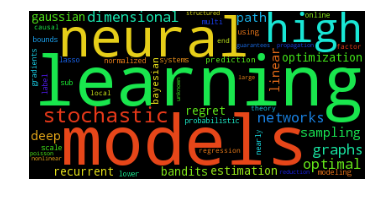

Topic: 1


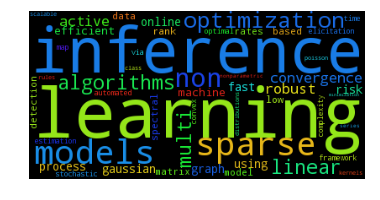

Topic: 2


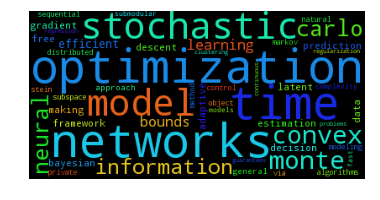

Topic: 3


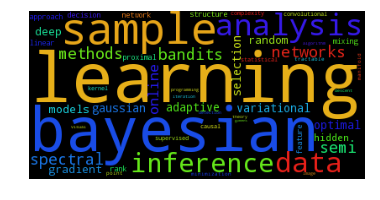

Topic: 4


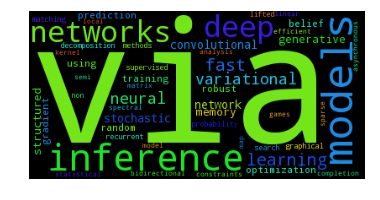

In [13]:
for i, top in enumerate(topics):
    print 'Topic:', i
    wc.generate_from_frequencies([(t[1],t[0]) for t in top])
    img = wc.to_image()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

#### Inference of topic distribution for a given paper title

In [14]:
ldamodel[corpus[3]]

[(0, 0.020296707147819698),
 (1, 0.91866372022869935),
 (2, 0.02047107101669236),
 (3, 0.020254855248982958),
 (4, 0.02031364635780571)]

Since we are modeling the paper title generating process as a probability distribution of topics, each of which is a probability distribution of words, we can use this generating process to suggest keywords for each title. These keywords may or may not show up in the title itself.

In [15]:
def gen_keywords(model,corp_doc,n_keywords=3):
    td = model[corp_doc]
    td = np.array([p[1] for p in td])
    
    topics = model.show_topics(num_words=100,formatted=False)
    rnd_topics = td.cumsum().searchsorted(np.random.sample(n_keywords))
    
    rnd_word = []
    for i in rnd_topics:
        topics_wrd_prbs = np.array([p[0] for p in topics[i]])
        rnd = np.random.sample(1)
        topics_wrd_prbs = topics_wrd_prbs / topics_wrd_prbs.sum() ## Since only tope 100 words. Doesn't sum to 1. 
        rnd_wrd = topics_wrd_prbs.cumsum().searchsorted(rnd)
        rnd_wrd = np.array([p[1] for p in topics[i]])[rnd_wrd[0]]
        rnd_word.append(rnd_wrd)
    return rnd_word

In [16]:
for i in range(10):
    print "\n================\n"
    print titles[i]
    print 'Generated Keywords:', gen_keywords(ldamodel,corpus[i],n_keywords=3)



Double or Nothing: Multiplicative Incentive Mechanisms for Crowdsourcing
Generated Keywords: [u'iteration', u'inference', u'theory']


Learning with Symmetric Label Noise: The Importance of Being Unhinged
Generated Keywords: [u'uncertainty', u'randomized', u'neural']


Algorithmic Stability and Uniform Generalization
Generated Keywords: [u'spatial', u'robust', u'dimensional']


Adaptive Low-Complexity Sequential Inference for Dirichlet Process Mixture Models
Generated Keywords: [u'rates', u'fast', u'based']


Covariance-Controlled Adaptive Langevin Thermostat for Large-Scale Bayesian Sampling
Generated Keywords: [u'monte', u'neural', u'stochastic']


Robust Portfolio Optimization
Generated Keywords: [u'learning', u'online', u'matrix']


Logarithmic Time Online Multiclass prediction
Generated Keywords: [u'complexity', u'problems', u'stein']


Planar Ultrametric Rounding for Image Segmentation
Generated Keywords: [u'deep', u'graphs', u'neural']


Expressing an Image Stream with a Seque

#### Entropy and the most "interdisciplinary" paper title

While some titles are strongly associated with a single topic. Other seem to be generated from a more even distribution over topics. Paper titles with more equal representation over topics could be considered to be, in some way, more _interdisciplinary_. To find these papers, we'll first find which paper titles have the highest information entropy in their infered topic distribution.

In [17]:
def document_topic_entropy(topic_ditribution):
    probs = np.array([td[1] for td in topic_ditribution])
    ent = -sum(probs * np.log(probs))
    return ent

Calculate the topic entropy of each title and show those with the highest entropy:

In [18]:
ents = [document_topic_entropy(ldamodel[c]) for c in corpus]
ent_df = pd.DataFrame({'title':titles,'TopicEntropy':ents})

In [19]:
for r in ent_df.sort('TopicEntropy',ascending=False).head(10).iterrows():
    print r[1]['TopicEntropy'], r[1]['title']

1.22769364291 Where are they looking?
1.1794725784 Bayesian dark knowledge
1.11261338284 Stochastic Variational Information Maximisation
1.06836891546 Variational inference with copula augmentation
1.06224431711 Adaptive Stochastic Optimization: From Sets to Paths
1.04994413148 The Population Posterior and Bayesian Inference on Streams
1.01801236048 Revenue Optimization against Strategic Buyers
1.01652797194 Fast Convergence of Regularized Learning in Games
0.993789478925 Communication Complexity of Distributed Convex Learning and Optimization
0.990764728084 Local Expectation Gradients for Doubly Stochastic Variational Inference


So it looks like by this method, the 'Where are they looking' has the highest entropy as a result of topic uncertainty, more than an real multi-topic content.